In [ ]:
import pickle
def store_data(var, path):
    with open(path+'.pkl', 'wb') as file:
        pickle.dump(var, file)

def load_data(path):    
    with open(path+'.pkl', 'rb') as file:
        var = pickle.load(file)
    return var

path = '/content/drive/MyDrive/My_PY_Notebooks/Thesis/'
import json
with open('/content/drive/MyDrive/My_PY_Notebooks/Thesis/4-model-dataset.json') as f:
  org_data = json.load(f, strict=False)

#Get user pair and its rouge

In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=d408f04a9bac57c226cf5f3ce3223445aac894ad91de565cca487ece1f808e68
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


In [ ]:
for doc_id, info in org_data.items():
  print(doc_id)
  print(info['m_dict'].keys())
  break

N24110
dict_keys(['1', '2', '3', '6'])


In [ ]:
# scores = scorer.score(u_summ, m_summ)
model_ordered_lst = list(org_data['N24110']['m_dict'].keys())

pair_lst =[]
for doc_id, info in org_data.items():
  u_list = list(info['u_dict'].keys())
  flg=0
  for i in range(len(u_list)):
    for j in range(len(u_list)):
      
      
      u_id1, u_id2 = u_list[i], u_list[j]
      if u_id1 == u_id2:
        flg=1
        continue
      pair_info = []
      u_summ1 = info['u_dict'][u_id1]
      u_summ2 = info['u_dict'][u_id2]
      
      u_scores = scorer.score(u_summ1, u_summ2)
      u_scores = round(u_scores['rougeL'][2], 5) #(round(u_scores['rouge1'][2], 5), round(u_scores['rouge2'][2], 5), round(u_scores['rougeL'][2], 5))

      pair_info.append(doc_id)
      pair_info.append([u_id1, u_id2])
      pair_info.append(u_scores)

      for model_name in model_ordered_lst:
        m_summ1 = info['m_dict'][model_name][u_id1]
        m_summ2 = info['m_dict'][model_name][u_id2]
        m_scores = scorer.score(m_summ1, m_summ2)
        m_scores = round(m_scores['rougeL'][2], 5) #(round(m_scores['rouge1'][2], 5), round(m_scores['rouge2'][2], 5), round(m_scores['rougeL'][2], 5))
        pair_info.append(m_scores)

    
    pair_lst.append(pair_info)


In [ ]:
len(pair_lst), pair_lst[:2] #prev: 20554

(20554,
 [['N24110', ['NT1', 'NT100'], 0.44444, 1.0, 1.0, 0.92308, 1.0],
  ['N24110', ['NT3', 'NT100'], 0.26667, 1.0, 1.0, 0.92308, 1.0]])

In [ ]:
store_data(pair_lst, path+'pair_lst')
# pair_lst = load_data('/content/pair_lst')
# pair_lst = pair_lst[:50]
# pair_lst[:3]

In [ ]:
user_pairs = set()
for lst in pair_lst:
  # print(lst)
  user_pairs.add((lst[1][0], lst[1][1]))

len(user_pairs) # without swap: 3854, with : 5589 (prev: 3953)

5589

In [ ]:
p = ['NT11', 'NT100']
i,j=0,0
user_pairs = list(user_pairs)
for lst in user_pairs:
  if lst[0]==p[0] and lst[1]==p[1]:
    j+=1
  if lst[0]==p[0][1] and lst[1]==p[0][0]:
    print(lst[0], p[1] ," : ", lst[1], p[0])
    i+=1
i,j

(0, 1)

In [ ]:
lst[0], lst[1], p[0][1], p[0][0]

('NT69', 'NT98', 'NT100', 'NT11')

In [ ]:
store_data(pair_lst, path+'pair_lst_with_rougeL_all_comb') #including (a,b) and (b,a)
# pair_lst[:3]
# pair_lst = load_data(path+'pair_lst')
pair_lst[:3]

[['N24110', ['NT1', 'NT100'], 0.44444, 1.0, 1.0, 0.92308, 1.0],
 ['N24110', ['NT3', 'NT100'], 0.26667, 1.0, 1.0, 0.92308, 1.0],
 ['N24110', ['NT11', 'NT100'], 0.125, 0.7619, 0.92857, 1.0, 1.0]]

#get users propotion 

In [ ]:
# [['N24110',
#   ('NT11', 'NT100'),
#   (0.25, 0.0, 0.125),
#   (0.7619, 0.73684, 0.7619),
#   (0.92857, 0.92308, 0.92857),
#   (1.0, 1.0, 1.0),
#   (1.0, 1.0, 1.0)]]
user_pairs = list(user_pairs)

In [ ]:
user_pairs[0], user_pairs[0][0], user_pairs[0][1]

(('NT34', 'NT97'), 'NT34', 'NT97')

In [ ]:
len(user_pairs)

5589

In [ ]:
user_idx = 2
pair_dct ={}
j=0
for pair in user_pairs:
  pair_score = 0
  i=0
  for lst in pair_lst:
    # print(pair[0], lst[1][0], pair[1], lst[1][1])
    if pair[0]==lst[1][0] and pair[1]==lst[1][1]:
      i+=1
      pair_score += lst[user_idx]

  if i:
    j+=i
    pair_dct[pair] = 1 - (pair_score/ i) #dist = 1 - cosine sim

len(pair_dct)

5589

In [ ]:
#avg rev pair
i=0
user_pair_dct_rev_avged = {}
rev_pair_set =set()
for pair in pair_dct:
  # print(pair[0], pair[1])
  
  rev_pair = ((pair[1], pair[0]))
  # print(rev_pair[0], rev_pair[1], rev_pair)
  
  if pair not in rev_pair_set:
    if pair_dct.get(rev_pair, 0):
      i+=1
      a = pair_dct[pair]
      b = pair_dct[rev_pair]
      user_pair_dct_rev_avged[pair] = (a+b)/2
      rev_pair_set.add(rev_pair)
    else:
      user_pair_dct_rev_avged[pair] = pair_dct[pair]


i, len(user_pair_dct_rev_avged)

(1733, 3858)

In [ ]:
d = {('NT61', 'NT103') : 0.2, ('NT103', 'NT61') : 0.3}
i=0
new = {}
rev_pair_set =set()
for pair in d:
  print(pair[0], pair[1])
  
  rev_pair = ((pair[1], pair[0]))
  print(rev_pair[0], rev_pair[1], rev_pair)
  
  if pair not in rev_pair_set:
    if d[rev_pair]:
      i+=1
      a = d[pair]
      b = d[rev_pair]
      print(a, b)
      new[pair] = (a+b)/2
      rev_pair_set.add(rev_pair)

i, len(new)

NT61 NT103
NT103 NT61 ('NT103', 'NT61')
0.2 0.3
NT103 NT61
NT61 NT103 ('NT61', 'NT103')


(1, 1)

In [ ]:
# d[('NT103', 'NT61')]
# rev_pair[0], d.get(rev_pair[0], 0),
# d = {('NT61', 'NT103') : 0.2, ('NT103', 'NT61') : 0.3}
# d[('NT103', 'NT61')]

NAML_idx = 4 #naml score is at id 4
pair_dct ={}
j=0
NAMl_pair_dct = {}
for pair in user_pairs:
  pair_score = 0
  i=0
  for lst in pair_lst:
    # print(pair[0], lst[1][0], pair[1], lst[1][1])
    if pair[0]==lst[1][0] and pair[1]==lst[1][1]:
      i+=1
      pair_score += lst[NAML_idx]

  if i:
    j+=i
    NAMl_pair_dct[pair] = 1 - (pair_score/ i) 

len(NAMl_pair_dct)

5589

In [ ]:
#avg rev pair
i=0
NAML_pair_dct_rev_avged = {}
rev_pair_set =set()
for pair in NAMl_pair_dct:
  # print(pair[0], pair[1])
  
  rev_pair = ((pair[1], pair[0]))
  # print(rev_pair[0], rev_pair[1], rev_pair)
  
  if pair not in rev_pair_set:
    if NAMl_pair_dct.get(rev_pair, 0):
      i+=1
      a = NAMl_pair_dct[pair]
      b = NAMl_pair_dct[rev_pair]
      NAML_pair_dct_rev_avged[pair] = (a+b)/2
      rev_pair_set.add(rev_pair)
    else:
      NAML_pair_dct_rev_avged[pair] = NAMl_pair_dct[pair]

i, len(NAML_pair_dct_rev_avged)

(1208, 4533)

In [ ]:
NAML_pair_propotion = {}
for pair in user_pair_dct_rev_avged:
  user_score, model_score = 0,0
  if user_pair_dct_rev_avged.get(pair, 0):
    user_score = user_pair_dct_rev_avged [pair]
  if NAML_pair_dct_rev_avged.get(pair, 0):
    model_score = NAML_pair_dct_rev_avged[pair]
  if user_score and model_score:
    NAML_pair_propotion[pair] = min(user_score, model_score) / max(user_score, model_score) if max(user_score, model_score) else 0

len(NAML_pair_propotion)

2517

In [ ]:
NAML_pair_propotion

{('NT84', 'NT94'): 0.05847278259522279,
 ('NT49', 'NT75'): 0.38768200459009,
 ('NT25', 'NT97'): 0.5105533950855744,
 ('NT59', 'NT97'): 0.4861965374907772,
 ('NT82', 'NT41'): 0.01332071164577143,
 ('NT74', 'NT41'): 0.1278083786224427,
 ('NT50', 'NT103'): 0.0700990269147843,
 ('NT65', 'NT98'): 0.13151001244718805,
 ('NT4', 'NT80'): 0.09616017161244186,
 ('NT83', 'NT69'): 0.9727290517906271,
 ('NT19', 'NT103'): 0.10324565626165548,
 ('NT102', 'NT64'): 0.0671742749342247,
 ('NT103', 'NT73'): 0.03240615179619007,
 ('NT51', 'NT69'): 0.18181999999999998,
 ('NT90', 'NT53'): 0.07020748344813754,
 ('NT3', 'NT75'): 0.38915759774284553,
 ('NT24', 'NT75'): 0.1887975937201967,
 ('NT36', 'NT68'): 0.12036515433837446,
 ('NT81', 'NT101'): 0.11649764682984418,
 ('NT31', 'NT92'): 0.026790517307627795,
 ('NT101', 'NT62'): 0.053612591380910526,
 ('NT102', 'NT85'): 0.017587757774290277,
 ('NT68', 'NT60'): 0.01847245776019094,
 ('NT69', 'NT60'): 0.3842535754198993,
 ('NT72', 'NT89'): 0.26075738957072425,
 ('

#edins


In [ ]:
import numpy as np
import scipy as sp
from scipy.special import softmax, kl_div
import pickle
from collections import OrderedDict

def jsd(p, q):

  p, q = np.asarray(p), np.asarray(q)

  if p.sum():
        p = p/p.sum()

  if q.sum():
      q = q/q.sum()

  # p = softmax(p)
  # q = softmax(q)

  m = 0.5 * (p + q)
  return 0.5 * sum(kl_div(p, m)) + 0.5 * sum(kl_div(q, m))

def calculate_penalty_factor_of_user(dataset, m_id, uid, uid2):
    
    def dev(uid1, uid2, model_summ_dict, base_summ_dist):
        '''
            Deviation of summary of uid wrt all other summaries 
        '''
        dev_sum = 0
        w = OrderedDict() # so that it'll same order while fetching values and storing back from list 
        lst = []
        i=0

        # calculate weights 
        # for uid2 in model_summ_dict:
            # to make sure each list contains score of same sequence of words
        p, q, r = [], [], []
        for word in model_summ_dict[uid2]:
            p.append(model_summ_dict[uid1][word])
            q.append(model_summ_dict[uid2][word])
            r.append(base_summ_dist[word])

        w[uid2] = jsd(p, q) / jsd(p, r) if jsd(p, r) else 0

        '''
        #since no loop
        lst.append(w[uid2])

        # apply softmax and store back to dict
        lst = softmax(np.array(lst))
        for uid2 in model_summ_dict:
            w[uid2] = lst[i]
            i+=1'''
        dct = {}
        # for uid2 in model_summ_dict:
        # if uid1 != uid2:
        p, q = [], []
        for word in model_summ_dict[uid2]:
            p.append(model_summ_dict[uid1][word])
            q.append(model_summ_dict[uid2][word])
        val = w[uid2] * jsd(p, q) if w[uid2] else 0
        dct[uid2] = val
        dev_sum += val

        return dev_sum, dct
    
    ratio_wrt_doc = 0
    i=0
    edins_pair = {}

    # for pair in NAML_pair_propotion:
    #   uid, uid2 = pair[0], pair[1]
    for doc_id in dataset:
        ratio_wrt_summ = 0
        model_summ_dict = dataset[doc_id]['m_dict'][m_id]
        key = model_summ_dict.keys()
        if uid in key and uid2 in key:
            user_summ_dict = user_data[doc_id]['u_dict']
            
            val, u_dct = dev(uid, uid2, user_summ_dict, dataset[doc_id]['doc_text'])
            val, m_dct = dev(uid, uid2, model_summ_dict, dataset[doc_id]['doc_text'])
            i+=1
            ratio_wrt_uid2 = 0
            # for uid2 in u_dct:
            u = u_dct[uid2]
            m = m_dct[uid2]
            if max(u, m):
                ratio_wrt_uid2 = (min(u, m) / max(u, m))
            else:
                ratio_wrt_uid2 = 0
            
            # if len(u_dct):
            #     ratio_wrt_uid2 /= len(u_dct)

            ratio_wrt_doc += ratio_wrt_uid2
        else:
          continue
      
    ratio_wrt_doc /= i
      #edins_pair[pair] = ratio_wrt_doc

    return ratio_wrt_doc

In [ ]:
user_data = load_data('/content/drive/MyDrive/My_PY_Notebooks/Thesis/data_with_distb_v3_roberta')
model_data = load_data('/content/drive/MyDrive/My_PY_Notebooks/Thesis/data_with_distb_NAML_roberta')
m_id = '2'
NAML_rouge_edins_propotion ={}
for pair in NAML_pair_propotion:
  uid1, uid2 = pair[0], pair[1]
  dev_over_all_pairs = calculate_penalty_factor_of_user(model_data, m_id,uid1, uid2)
  NAML_rouge_edins_propotion[pair] = [NAML_pair_propotion[pair], dev_over_all_pairs]
  # break

len(NAML_rouge_edins_propotion) # {('NT84', 'NT94'): [0.05847278259522279, 0.09288730336629016]}

2517

In [ ]:
NAML_rouge_edins_propotion_lst = [ [pair, NAML_rouge_edins_propotion[pair][0], NAML_rouge_edins_propotion[pair][1]] for pair in NAML_rouge_edins_propotion]

In [ ]:
store_data(NAML_rouge_edins_propotion_lst, path+'NAML_rouge_edins_propotion_lst')

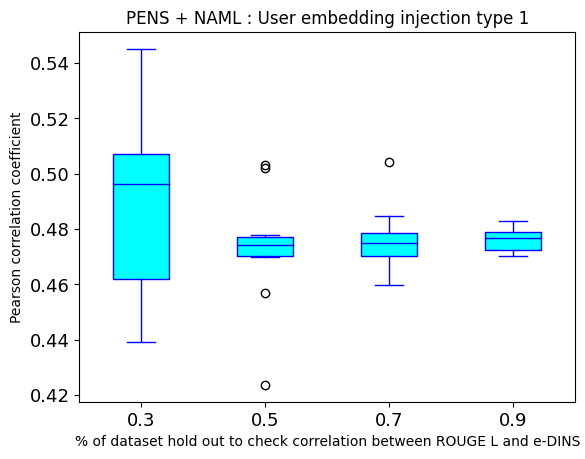

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, pairs):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(pairs) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []

    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            e_DINS_lst, r1_lst, r2_lst, rl_lst = [], [], [], []
            # for i in range(0, 5): # collect distb using 5 differnt rouge set to calculate co rel
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              rl_lst.append(pairs[idx][1])
              e_DINS_lst.append(pairs[idx][2])
                
            correl = find_corr(e_DINS_lst, rl_lst, method='pearson')
            correl_rl_lst.append(correl)
            
        # per_wise_correl_r1_lst.append(correl_r1_lst)
        # per_wise_correl_r2_lst.append(correl_r2_lst)
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.30, 0.50, 0.70, 0.90]#, 2000, 2500, 3000, 3500]
plot_data_pearson = box_plot_data2(percent_data_lst, NAML_rouge_edins_propotion_lst)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], percent_data_lst)

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation between ROUGE L and e-DINS', fontsize = 10)
plt.ylabel('Pearson correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1')
plt.show()

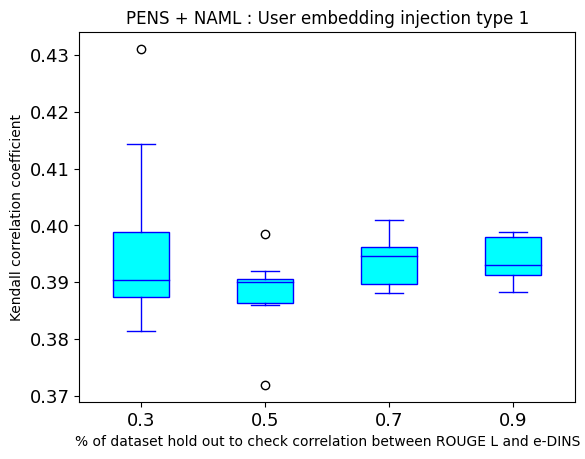

In [ ]:
 def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, pairs):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(pairs) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []

    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            e_DINS_lst, r1_lst, r2_lst, rl_lst = [], [], [], []
            # for i in range(0, 5): # collect distb using 5 differnt rouge set to calculate co rel
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              rl_lst.append(pairs[idx][1])
              e_DINS_lst.append(pairs[idx][2])
                
            correl = find_corr(e_DINS_lst, rl_lst, method='kendall')
            correl_rl_lst.append(correl)
            
        # per_wise_correl_r1_lst.append(correl_r1_lst)
        # per_wise_correl_r2_lst.append(correl_r2_lst)
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.30, 0.50, 0.70, 0.90]#, 2000, 2500, 3000, 3500]
plot_data_pearson = box_plot_data2(percent_data_lst, NAML_rouge_edins_propotion_lst)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], percent_data_lst)

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation between ROUGE L and e-DINS', fontsize = 10)
plt.ylabel('Kendall correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1')
plt.show()

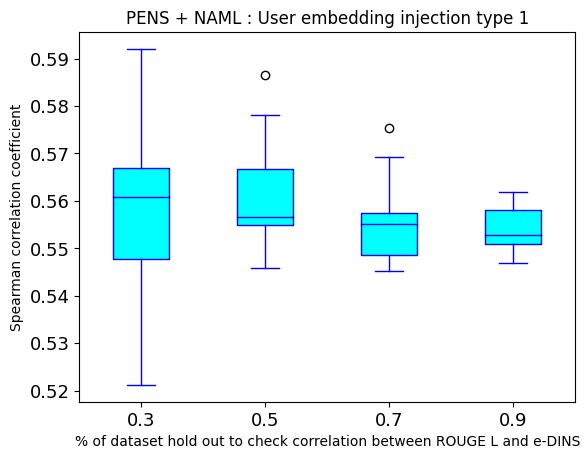

In [ ]:
import random
import pandas as pd
from matplotlib import pyplot as plt 
def find_corr(edins, rl_lst, method='pearson'):
    edins = pd.Series(edins)
    rl_lst = pd.Series(rl_lst)
    correlation_with_rl = edins.corr(rl_lst, method=method)

    return correlation_with_rl

def box_plot_data2(percent_data_lst, pairs):
    
    plot_data1 = []
    plot_data2 = []
    no_of_pairs = len(pairs) 
    gamma=1
    per_wise_correl_r1_lst, per_wise_correl_r2_lst, per_wise_correl_rl_lst = [], [], []

    for per in percent_data_lst:
        data_for_doc1 = []
        data_for_doc2 = []
        correl_r1_lst, correl_r2_lst,correl_rl_lst =[], [], []
        for z in range(0, 10): # find co rel n times 
            e_DINS_lst, r1_lst, r2_lst, rl_lst = [], [], [], []
            # for i in range(0, 5): # collect distb using 5 differnt rouge set to calculate co rel
                
            randomlist = random.sample(range(0, no_of_pairs), int(no_of_pairs * per))

            for idx in randomlist:
              rl_lst.append(pairs[idx][1])
              e_DINS_lst.append(pairs[idx][2])
                
            correl = find_corr(e_DINS_lst, rl_lst, method='spearman')
            correl_rl_lst.append(correl)
            
        # per_wise_correl_r1_lst.append(correl_r1_lst)
        # per_wise_correl_r2_lst.append(correl_r2_lst)
        per_wise_correl_rl_lst.append(correl_rl_lst)
        
    return per_wise_correl_rl_lst

percent_data_lst = [0.30, 0.50, 0.70, 0.90]#, 2000, 2500, 3000, 3500]
plot_data_pearson = box_plot_data2(percent_data_lst, NAML_rouge_edins_propotion_lst)

def box_plot1(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

    return bp

fig, ax = plt.subplots()
bp2 = box_plot1(plot_data_pearson, 'blue', 'cyan')
plt.xticks([1, 2, 3, 4], percent_data_lst)

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.xlabel('% of dataset hold out to check correlation between ROUGE L and e-DINS', fontsize = 10)
plt.ylabel('Spearman correlation coefficient', fontsize = 10)
plt.title('PENS + NAML : User embedding injection type 1')
plt.show()

In [ ]:
# NAML_pair_propotion
for pair in NAML_pair_propotion:
  print(pair[0], pair[1], pair)
  break

NT84 NT94 ('NT84', 'NT94')


#darsh code

In [ ]:
# scores = scorer.score(u_summ, m_summ)
model_ordered_lst = list(org_data['N24110']['m_dict'].keys())

pair_lst =[]
for doc_id, info in org_data.items():
    u_list = list(info['u_dict'].keys())
    print(u_list)
    flg=0
    for i in range(len(u_list)):
        for j in range(len(u_list)):
            u_id1, u_id2 = u_list[i], u_list[j]
            # print(u_id1, u_id2)
            if u_id1 == u_id2:
              flg=1
              continue
            pair_info = []
            u_summ1 = info['u_dict'][u_id1]
            u_summ2 = info['u_dict'][u_id2]
            
            u_scores = scorer.score(u_summ1, u_summ2)
            u_scores = round(u_scores['rougeL'][2], 5) #(round(u_scores['rouge1'][2], 5), round(u_scores['rouge2'][2], 5), round(u_scores['rougeL'][2], 5))

            pair_info.append(doc_id)
            pair_info.append((u_id1, u_id2))
            pair_info.append(u_scores)

            for model_name in model_ordered_lst:
              m_summ1 = info['m_dict'][model_name][u_id1]
              m_summ2 = info['m_dict'][model_name][u_id2]
              m_scores = scorer.score(m_summ1, m_summ2)
              m_scores = round(m_scores['rougeL'][2], 5) #(round(m_scores['rouge1'][2], 5), round(m_scores['rouge2'][2], 5), round(m_scores['rougeL'][2], 5))
              pair_info.append(m_scores)

            # print(pair_info)
      
            pair_lst.append(pair_info)


print(pair_lst)